# **ACTIVIDAD EVALUATIVA: MÉTODOS ESTADÍSTICOS AVANZADDOS**

## Resumen:

El presente trabajo se realizó como componente evaluativo de la materia Métodos Estadísticos Avanzados, dictada en el segundo semestre de la Maestría en Ciencia de Datos y Analítica de la Universidad EAFIT para el periodo 2020-2, en donde, se debe crear un modelo o varios modelos que permitan caracterizar la relación entre las variables PIB, Inflación, Desempleo, Tasa de Cambio, Balance Fiscal, Balance en Cuenta Corriente, Tasa de Intervención, TRM, versus los costos de ventas de las empresas registradas en las bases de datos de la Superintendencia de Sociedades de Colombia cuyos datos fueron tomados de los años 2016, 2017, 2018 y 2019.

### Docente

Phd. Juan David Ospina

### Integrantes

*   Javier Leomar Matamoros
*   Juan David Botero
*   Sebastián Obando
*   Andrés Castro

### **Estimación de esfuerzo:**
Para la estimación se hará uso de una escala de **1-5**
*  Consolidación de información: **4**
*  Transformación de varibles y análisis descriptivo: **3**
*  Ajuste y validación de modelos: **4**
*  Redacción del reporte: **2**

## Repositorio:

El desarrollo de la presente actividad también se encuentra en:

https://github.com/andrec230/MicroServicios/blob/master/MODELO_C1.ipynb

## Requerimientos para la ejecución del proyecto:

El proyecto se desarrolló sobre un Jupyter Notebook en Anaconda, utilizando Python, son las siguientes librerias:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error,r2_score

%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# DESARROLLO DE LA ACTIVIDAD

El método utilizado para desarrolla esta actividad fue tomado del curso "Complete 2020 Data Science & Machine Learning Bootcamp" creado por Philipp Muellauer y Dr. Angela Yu en udemy, para más información ver: https://www.udemy.com/course/python-data-science-machine-learning-bootcamp/#instructor-1, el cual consta de 6 pasos:

1. Formulación de la pregunta: ¿Cuál es el problema?
2. Recolección de datos: ¿Cuáles son los datos?
3. Limpieza de datos: ¿Cómo se necesitan los datos?
4. Exploración y visualización: ¿Qué comportamiento preliminares generan insights para el modelo a utilizar?
5. Entrenamiento del algoritmo: ¿Cuál es el modelo y su entrenamiento para generar la predicción?
6. Evaluación: ¿Qué tan ajustado o no se encuentra el modelo final?

Estos pasos son muy comunes en todo proyecto de ciencia de datos, por lo cual se aplicaron con leves variaciones en el presente trabajo, con el fin de tener una forma organizada y practica de desarrollarlo.

## 1. FORMULACIÓN DE LA PREGUNTA

Para darle un foco más robusto a la actividad se plantea la siguiente pregunta a responder:

¿Cómo calcular los costos de ventas para 2020 de cada empresa de un sector en específico basado en 4 observaciones por empresa (2016,2017,2018,2019)? 

Para resolver esta pregunta, es necesario entender si lo que se quiere predecir un valor partiendo de cuatro datos históricos, si es asi, no habría suficiente capacidad de "aprendizaje" para realizar esta azaña con una regresión lineal simple, pero si en lugar de intentar predecir por ejemplo, los costos de ventas de una sola empresa, usaramos la variabilidad contenida entre multiples empresas que comparten simulitudes como el sector al cuál pertencen y si son micro, pequeñas, medianas o grandes empresas, tal vez habría una mayor probabilidad de entender cuál sería el costo en ventas de una empresa e incluso la sumatoria de todas estas predicciones sería el equivalente al del sector de la economía al cual pertenecen dichas empresas.

Por lo tanto, una aproximación interesante que cumple con el planteamiento anterior reside en un método de la estadística avanzada llamado **modelos con efectos mixtos**, el cuál se utilizó para responder la pregunta planteada, como se puede ver a continuación.

# 2. RECOLECCIÓN DE DATOS

El primer paso en la búsqueda de la respuesta a la pregunta planteada, consiste en reunir los datos, hacer un porceso de limpieza y organizarlos.

Para la recolección de datos se utilizaron dos fuentes:

1. Bases de datos de la superintendencia de sociedades, la cual contiene el estado de resultados de empresas colombianas obligadas a reportar sus comportamientos financieros año a año por el gobierno de Colombia.
2. Resultados de los indicadores macroeconomicos del páis publicados por le Banco de la República y disponibles en su sitio web.

### 2.1. Datos de la Superintendencia de sociedades:

Se tomaron los datos de libros de excel descargados en la página 𝚑𝚝𝚝𝚙://𝚙𝚒𝚎.𝚜𝚞𝚙𝚎𝚛𝚜𝚘𝚌𝚒𝚎𝚍𝚊𝚍𝚎𝚜.𝚐𝚘𝚟.𝚌𝚘, en dónde se encontraron para cada los libros con los nombres Plenas - Individuales, Plenas - Separados, Pymes - Individuales, Pymes - Separados.

Los datos tomados fueron los de Plenas - Individuales por recomendación del profesor de la asignatura y las pestañas a utilizar como fuentes de datos fueron "Estado de Resultados Integral" o ERI y Carátulas, el primer caso contiene los datos de la variables "costos de ventas" y el segundo el código con el cuál se indetifica la actividad económica de una empresa, llamado Clasificación Industrial Internacional Uniforme (CIIU), este último utilizado como la definición del sector en el presente trabajo.

Dicho lo anterior se importan los datos de los estados de resultados y las carátulas como se muestra a continuación:

#### 2.1.1. Estado de resultados:

In [3]:
ERI_2016 = pd.read_excel("./data/2016.xlsx",sheet_name="ERI") 
ERI_2017 = pd.read_excel("./data/2017.xlsx",sheet_name="Estado de Resultado Integral")
ERI_2018 = pd.read_excel("./data/2018.xlsx",sheet_name="ERI")
ERI_2019 = pd.read_excel("./data/2019.xlsx",sheet_name="ERI")

#### 2.1.2. Carátulas:

Un observación importante, no hubo carátula en 2016 por lo tanto se utilizaron los datos de 2017 con el fin de rescatar tantas empresas y su relación con el sector cómo fue posible.

In [4]:
CARATULA_2016 = pd.read_excel("./data/2017.xlsx",sheet_name="Caratula") #2016 No tiene carátula
CARATULA_2017 = pd.read_excel("./data/2017.xlsx",sheet_name="Caratula")
CARATULA_2018 = pd.read_excel("./data/2018.xlsx",sheet_name="Carátula")
CARATULA_2019 = pd.read_excel("./data/2019.xlsx",sheet_name="Carátula")

###  2.2. Datos de variables macroeconomicas:

Estos datos se tomaron del Banco de la Repúbica en 𝚑𝚝𝚝𝚙𝚜://𝚠𝚠𝚠.𝚋𝚊𝚗𝚛𝚎𝚙.𝚐𝚘𝚟.𝚌𝚘/𝚎𝚜/-𝚎𝚜𝚝𝚊𝚍𝚒𝚜𝚝𝚒𝚌𝚊𝚜.

### Variables Macroeconomicas:

In [5]:
macroeconomicas = pd.read_excel("./data/Macroeconomicas.xlsx",sheet_name="BD") 

Las variables fueron:
    
    - Tasa de intervención
    - Balance en cuenta corriente
    - Inflación
    - Desempleo
    - PIB
    - TRM

Los datos monetarios estan representados en dólares.

## 3. LIMPIEZA

En este punto se depuran los datos de acuerdo a las necesidades del proceso de entranamiento, cómo una sola base de datos con una variable dependiente y **n** variables independentes, con registros únicos, sin datos nulos y la mayor consistencia entre variables a nivel de eliminación de variables redudantes y la agreación de cálculos o variables que faciliten los análisis.

## 3.1. Creación de la base de datos de empresas:

Debido a que el objetivo del trabajo es realizar el análisis sobre un solo sector, fue necesario organizar los datos de empresas, en especial, para analizar los sectores con el mayor volumén de empresas, de manera que se selecionará uno para llevar acabo el ejercicio.

### 3.1.1. Relaciones:

Debido a que los datos dependientes (costos de ventas) e independientes (variables macroeconomicas) se encuentran en bases de datos distintas es necesario unir ambas bases en una sola mediante relaciones, lo cual requiere una llave o una serie de llaves que son columnas o variables en común, por ejemplo el año y el nit.

In [6]:
df_2016 = pd.merge(CARATULA_2017, ERI_2016, how='right') #2016 no viene con el código CIIU
df_2017 = pd.merge(CARATULA_2017, ERI_2017, how='right')
df_2018 = pd.merge(CARATULA_2018, ERI_2018, how='right')
df_2019 = pd.merge(CARATULA_2019, ERI_2019, how='right')

### 3.1.2. Limpieza

Las bases de datos vienen en muchos casos con filas diplicadas, para los estados de resultados se mostraban los resultados del año en cuestión y el año anterior, lo cual al unir todas las bases implicaría la repetición de filas y por lo tanto es necesario dejar para cada año los valores de cierre de cada año, eliminando cualquier valor de años anteriores.

In [7]:
df_2017 = df_2017[df_2017["Periodo"] == "2017"]
df_2018 = df_2018[df_2018["Periodo"] == "Periodo Actual"]
df_2019 = df_2019[df_2019["Periodo"] == "Periodo Actual"]

### 3.1.3. Modificación o adición de variables para facilitar el análisis:

Se define una variable de año y una variable de conteo equivalente a 1 para cada registro para facilitar la manipulación de los datos.

#### 3.1.3.1. Años:

In [8]:
df_2016['año'] = 2016
df_2017['año'] = 2017
df_2018['año'] = 2018
df_2019['año'] = 2019

#### 3.1.3.2. Conteos:

In [9]:
df_2016['#'] = 1
df_2017['#'] = 1
df_2018['#'] = 1
df_2019['#'] = 1

### 3.1.4. Selección de variables:

La base de datos de estados financiero para cada año, venia con muchas más variables que el costo de ventas, por lo tanto en este punto se seleccionan las variables que finalmente se van a utilizar para la selección del sector a analizar.

Cabe resaltar que debido a que no existe un campo de tamaño de empresas, se plantea utilizar un cálculo de cuartiles con los ingresos de actividades ordinarias para aproximar esta clasificación.

In [10]:
vars = ['Nit','Clasificación Industrial Internacional Uniforme Versión 4 A.C','Costo de ventas','Ingresos de actividades ordinarias','año','#']

### 3.1.5. Uniones:

Los anteriores ejercicios se realizaron año a año, ahora se consolidan en una sola base.

In [11]:
df = df_2016[vars].append([df_2017[vars],df_2018[vars],df_2019[vars]])
df['Nit'] = df['Nit'].astype(str)
df = df[~df['Costo de ventas'].isnull()]
df.to_csv("df.csv")

## 3.2. Depuración de los sectores:

Los criterios de depuración utilizados para obtener los sectores con un volumén de información importante y consistente fueron:

1. Seleccionar las empresas que se mantuvieron durante los 4 años de datos
2. Seleccionar los sectores que tuvieran al menos 20 empresas
3. Seleccionar el sector que mejor se ajusta a los dos criterios anteriores

### 3.2.1. Selección de empresas que se mantienen durante los 4 años de observaciones

In [12]:
empresas = pd.pivot_table(df,values='#',index=['Nit','Clasificación Industrial Internacional Uniforme Versión 4 A.C'],columns='año', aggfunc=np.sum,fill_value=0).reset_index()
empresas['cumplen'] = np.where(((empresas[2016] > 0) & (empresas[2017] > 0) & (empresas[2018] > 0) & (empresas[2019] > 0)), 'SI', 'NO')
empresas = empresas[empresas["cumplen"]=="SI"]
empresas = empresas.sort_values(by="Nit")
empresas = empresas[['Nit','Clasificación Industrial Internacional Uniforme Versión 4 A.C']]
empresas['#'] = 1
empresas.head()

año,Nit,Clasificación Industrial Internacional Uniforme Versión 4 A.C,#
2,800003267.0,C1811 - Actividades de impresión,1
3,800004599.0,G4669 - Comercio al por mayor de otros product...,1
4,800005260.0,G4690 - Comercio al por mayor no especializado,1
6,800007193.0,A0126 - Cultivo de palma para aceite (palma af...,1
7,800007202.0,C2229 - Fabricación de artículos de plástico n...,1


### 3.2.2. Seleccionar los sectores que tienen al menos 20 empresas

<AxesSubplot:xlabel='#', ylabel='Clasificación Industrial Internacional Uniforme Versión 4 A.C'>

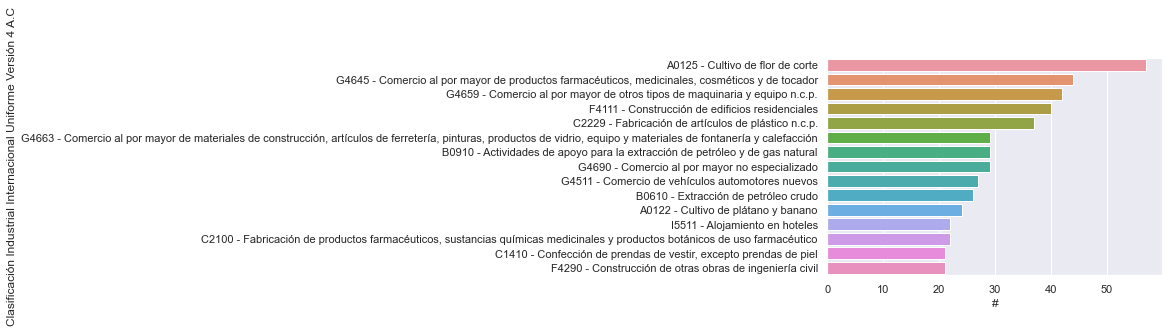

In [13]:
sectores = empresas.groupby("Clasificación Industrial Internacional Uniforme Versión 4 A.C")['#'].sum().reset_index().sort_values(by="#",ascending=False)
sectores = sectores[sectores["#"]>=20]
sns.barplot(y="Clasificación Industrial Internacional Uniforme Versión 4 A.C", x="#", data=sectores)

### 3.2.3. Seleccionar el sector que mejor se ajusta a los criterios anteriores

In [14]:
sector = 'A0125 - Cultivo de flor de corte'
empresas_seleccionadas = empresas[empresas['Clasificación Industrial Internacional Uniforme Versión 4 A.C']== sector]
empresas_seleccionadas = empresas_seleccionadas['Nit'].unique()
db = df[df['Nit'].isin(empresas_seleccionadas)]
db = db.drop(['#','Clasificación Industrial Internacional Uniforme Versión 4 A.C'],axis=1)
db.head()

,Nit,Costo de ventas,Ingresos de actividades ordinarias,año
14,800016390.0,7231141.0,9701699.0,2016
25,800021599.0,32251120.0,42889520.0,2016
27,800022398.0,8435911.0,13813861.0,2016
30,800023622.0,24344106.0,33688768.0,2016
38,800027543.0,13966425.0,19961244.0,2016


## 3.3. Obtención de la base de datos final

Se filtran los NITs que correspondan únicamente al sector seleccionado y se agregan las variables macroeconómicas, utilizando como llave el año.

In [15]:
df_sector = df[df["Nit"].isin(db["Nit"].unique())] # Filtro por el sector de interes
data = pd.merge(df_sector, macroeconomicas, how='left') # Adición de variables macroeconomicas
data = data.drop(["Clasificación Industrial Internacional Uniforme Versión 4 A.C","#"],axis=1) # Eliminación de variables inaportantes
data = data.rename(columns={'Ingresos de actividades ordinarias':'Ingresos_de_actividades_ordinarias','Costo de ventas': 'costo_de_ventas', 'año':'year', 'Nit':'nit', 'inflación': 'inflacion'}) # Renombramientos
data.head()

,nit,costo_de_ventas,Ingresos_de_actividades_ordinarias,year,tasa_de_intervencion,balance_en_cuenta_corriente_usd,inflacion,desempleo,pib_usd,trm
0,800016390.0,7231141.0,9701699.0,2016,0.071,-1203600,0.0752,0.0922,28312,3050.98
1,800021599.0,32251120.0,42889520.0,2016,0.071,-1203600,0.0752,0.0922,28312,3050.98
2,800022398.0,8435911.0,13813861.0,2016,0.071,-1203600,0.0752,0.0922,28312,3050.98
3,800023622.0,24344106.0,33688768.0,2016,0.071,-1203600,0.0752,0.0922,28312,3050.98
4,800027543.0,13966425.0,19961244.0,2016,0.071,-1203600,0.0752,0.0922,28312,3050.98


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   nit                                 228 non-null    object 
 1   costo_de_ventas                     228 non-null    float64
 2   Ingresos_de_actividades_ordinarias  228 non-null    float64
 3   year                                228 non-null    int64  
 4   tasa_de_intervencion                228 non-null    float64
 5   balance_en_cuenta_corriente_usd     228 non-null    int64  
 6   inflacion                           228 non-null    float64
 7   desempleo                           228 non-null    float64
 8   pib_usd                             228 non-null    int64  
 9   trm                                 228 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 19.6+ KB


## 3.4. Preprocesamiento:

Se aplica una remoción de los valores más extremos por cada empresa:

In [17]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [18]:
data = remove_outlier (data, 'costo_de_ventas')

Y se conservan las empresas que se conserven durante los cuatro años con datos de costos de ventas más estables

In [19]:
nits = data['nit'].value_counts().reset_index()
nits = nits[nits['nit']==4]
nits = list(nits['index'])
data = data[data['nit'].isin(nits)]

Con este ejercicio, fue posible pasar de 228 empresas a 192 empresas, cuyos datos son más estables.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 227
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   nit                                 192 non-null    object 
 1   costo_de_ventas                     192 non-null    float64
 2   Ingresos_de_actividades_ordinarias  192 non-null    float64
 3   year                                192 non-null    int64  
 4   tasa_de_intervencion                192 non-null    float64
 5   balance_en_cuenta_corriente_usd     192 non-null    int64  
 6   inflacion                           192 non-null    float64
 7   desempleo                           192 non-null    float64
 8   pib_usd                             192 non-null    int64  
 9   trm                                 192 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 16.5+ KB


# 4. EXPLORACIÓN Y VISUALIZACIÓN

Durante esta fase se realizan dos tipos de análisis, un análisis general por variable y un análisis general por variables vs cada empresa, con el fin de entender cuál es el comportamiento de cada variable en el tiempo y cómo afecta a las empresas del sector seleccionado, de manera que se aplique algun tratamiento de datos, transformación o selección de variables que sea claves para explicar el modelo final.

## 4.1. Estandarización de la variable de respuesta

Con el fin de mitigar el ruido generado por la escala del costo de ventas, se aplica un método de estandización, que muestra como se normalizan los datos alrededor del centro, para mejorar la capacidad de explicación que puedan tener las variables independientes sobre la variable objetivo.

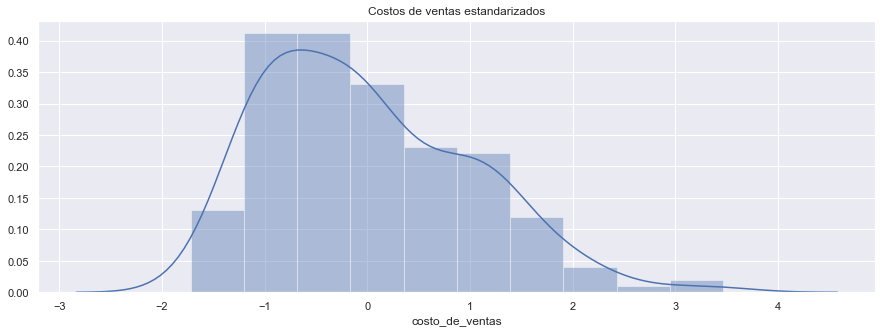

In [21]:
data["costo_de_ventas"] = preprocessing.scale(data["costo_de_ventas"].values)
fig, axs = plt.subplots(figsize=(15, 5))
ax1 = sns.distplot(data["costo_de_ventas"])
ax1.set_title("Costos de ventas estandarizados")
plt.show()

## 4.2. Subcategorización de la variable de respuesta por cuartiles

Partiendo del análisis anterior, se considera de valor el hecho de generar una subcategoría que divida en cuartiles a las empresas del sector, haciendo el símil de la clasificación por micro, pequeñas, medianas y grandes empresas en función del ingreso, de manera que se le de un sentido a los puntos más lejanos en función del contexto del ejercicio.

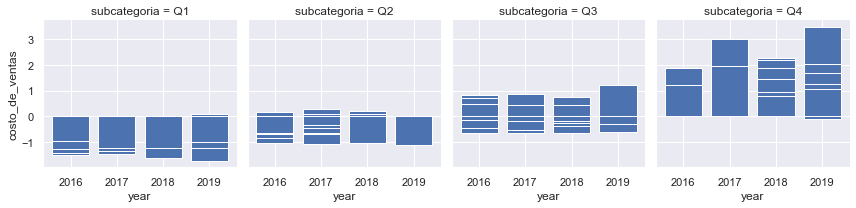

In [22]:
quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
data['subcategoria'] = pd.qcut(data['Ingresos_de_actividades_ordinarias'],  q=4, labels = quartiles )
data = data.drop('Ingresos_de_actividades_ordinarias',axis=1)
costo_subcategoria = data.groupby(['subcategoria','year'])['costo_de_ventas'].sum().reset_index()
sns.FacetGrid(data, col="subcategoria").map(plt.bar,'year','costo_de_ventas')
plt.show()

## 4.4. Análisis de la relación entre variables

Se analiza la fuerza con la que una variable explica a otra, para encontrar las variables que aportan y descartar del modelo las que no.

## 4.4.1. Comportamiento del costo de ventas en el tiempo

Se puede observar que para cada año ahy una distribución más conservadora entre las empresas, con unos poco puntos extremos, lo que indica que hay cierto grado de estabilidad año a año en el comportamiento del costo de ventas.

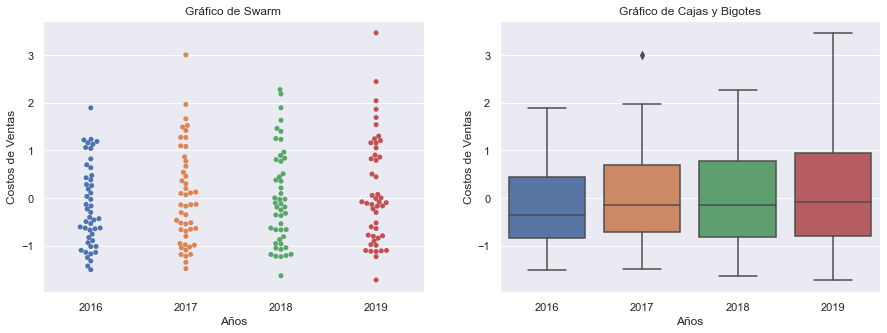

In [23]:
fig, axs = plt.subplots(1,2,figsize=(15, 5))
axs = axs.flatten()
ax1 = sns.swarmplot(x="year", y="costo_de_ventas", data=data, ax = axs[0])
ax2 = sns.boxplot(x="year", y="costo_de_ventas", data=data,ax = axs[1])
ax1.set(xlabel='Años', ylabel='Costos de Ventas')
ax1.set_title("Gráfico de Swarm")
ax2.set(xlabel='Años', ylabel='Costos de Ventas')
ax2.set_title("Gráfico de Cajas y Bigotes")

plt.show()

### 4.4.2. Distribución de variables

Las ditribuciones permiten intuir cuáles variables pueden presentar alguna correlación fuerte, cuándo marcan una tendencia, para este caso algunas variables que parecen correlacionadas son:
- El desempleo con el balance de cuenta corriente, aun que el 2016 no parece ser un buen año.
- El balance de cuenta corriente con la **TRM**, parece que inicia muy fuerte en 2016, puede ser que por eso no hubo una buena relación respecto al desempleo y el balance en cuenta corriente, lo que indica que la **TRM** puede tener un peso interesante en el comportamiento del mercado.
- El año (year) es un indicador que afecta completamente las variables macroeconómicas, dado que año a año las políticas del gobierno sufren cambios, por lo cual no es una variable tan categórica y es muy marcado frente a la tasa de intervención.
- Los costos de ventas son demasiado uniformes para todas las variables pero se distribuye en lineas, lo que puede marcar clústers o el comportamiento por cuartiles planteado para explicar el presente ejercicio.
- Hay un comportamiento claramente decreciente entre el PIB y la inflación, lo que podria implicar que una variable puede explicar perfectamente a la otra.

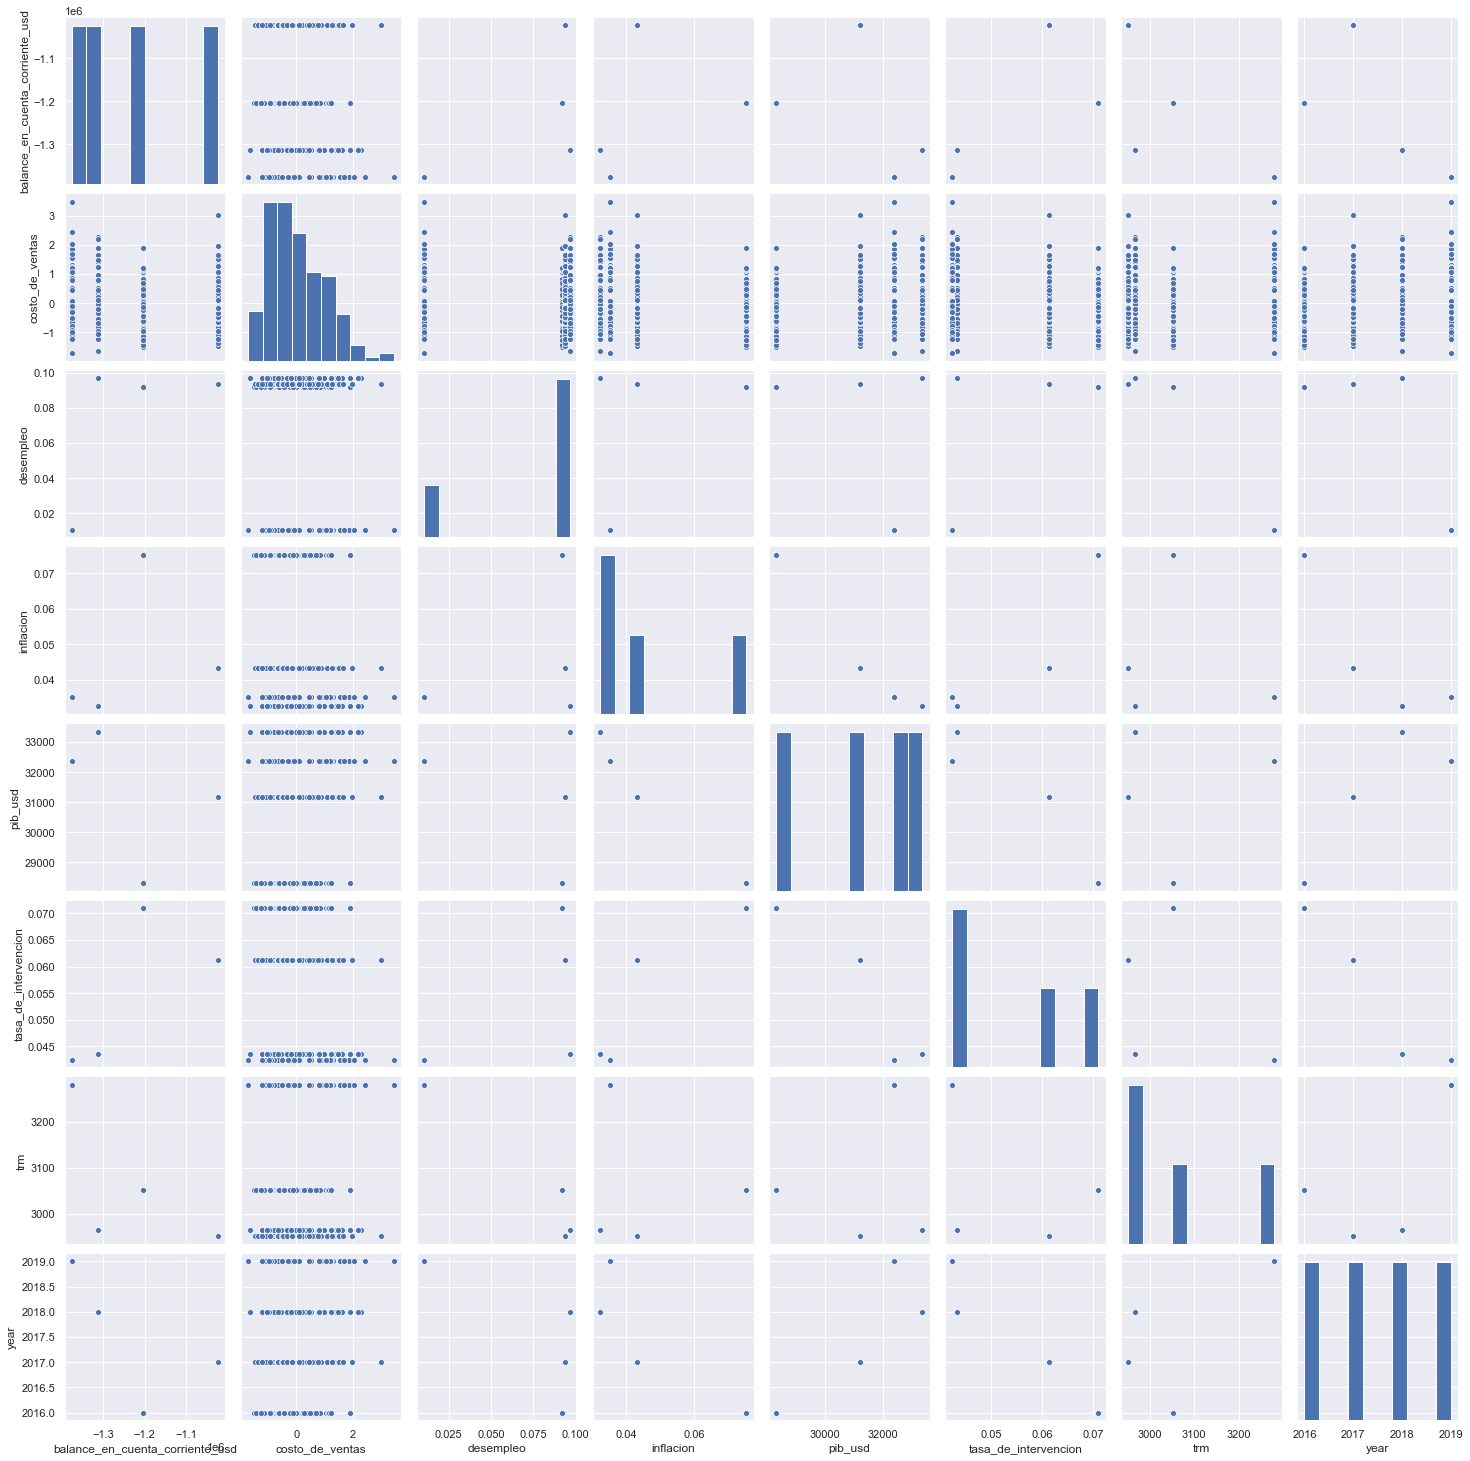

In [24]:
sns.pairplot(data[data.columns.difference(['nit'])])

### 4.4.3. Análisis de correlaciones

Los análisis de correlaciones permiten confirmar los supuestos de los análisis de distribuciones dado que calcula la capacidad de explicación entre pares de variables. Adicionalmente se calculan las matrices de correlaciones tanto a nivel general como por cuartil para descartar si existe una influencia más fuerte de ciertas variables sobre cuartiles específicos.

### 4.4.3.1. Correlaciones generales

Es muy bajo o nulo el nivel de explicación de las variables macroeconomicas frente a las particularidades de los costos de gastos, sin embargo el efecto del tiempo en relación a las variables macroeconómicas es notorio y algunas variables que tienen una fuerte relación entre sí son: 
- La tasa de intervención y el balance en cuenta corriente: 70%
- La tasa de intervención y la inflación:80%
- La tasa de intervención y relativamente el desempleo: 54%
- La tasa de intervención y el pib_usd: -94%
- El balance en cuenta corriente y el desempleo:62%
- El balance en cuenta corriente y la trm: -67%
- El demsempleo y la trm: -97%
- El pib con la inflación: -98%

Cómo podemos observar, la tasa de interveción y la **TRM** pueden estar conteniendo toda la capacidad interpretativa de las variables macroeconómicas analizadas.

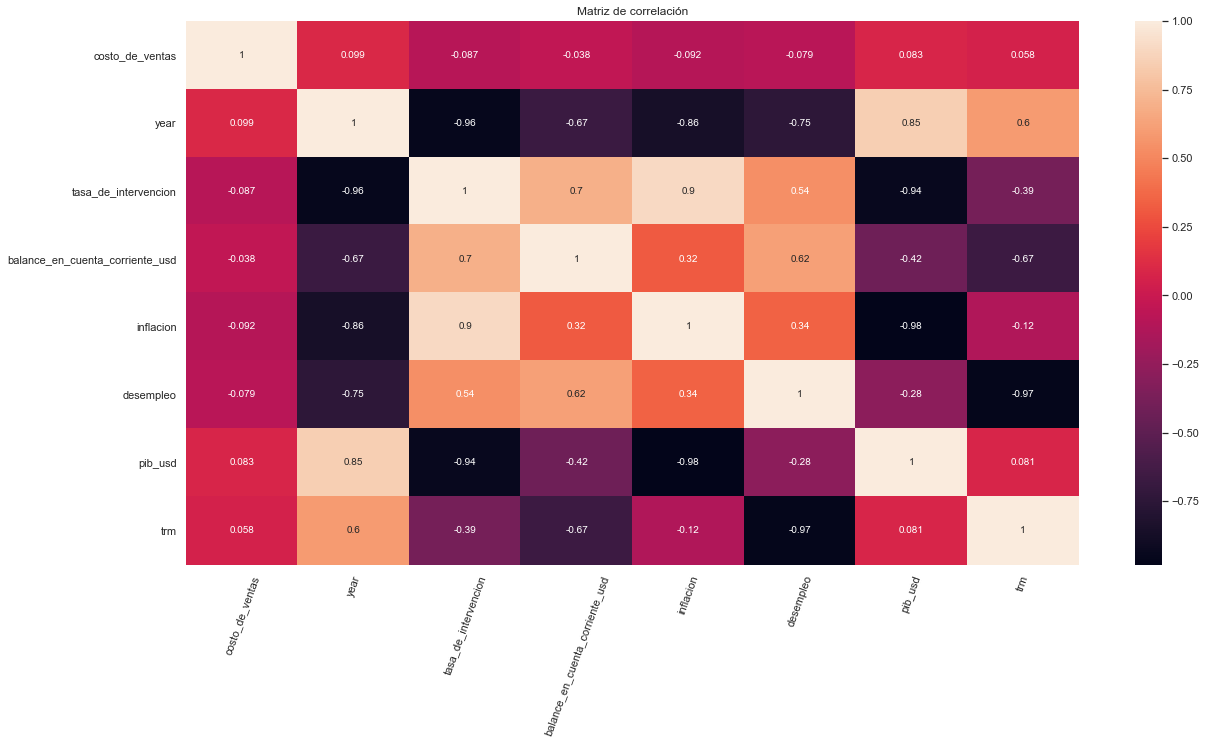

In [25]:
corrMatrix = data.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrMatrix, annot=True,ax=ax)
plt.title('Matriz de correlación')
plt.xticks(rotation=70)
plt.show()

### 4.4.3.1. Correlaciones Q1

En este punto sólo se quiere entender si mejora la capacidad interpretativa por cuartíl, para este caso sigue estando por debajo del 1% absoluto para cada variable.

In [26]:
data[data["subcategoria"]=="Q1"].corr()['costo_de_ventas']

costo_de_ventas                    1.000000
year                               0.169279
tasa_de_intervencion              -0.149796
balance_en_cuenta_corriente_usd   -0.171518
inflacion                         -0.100532
desempleo                         -0.174710
pib_usd                            0.101379
trm                                0.167831
Name: costo_de_ventas, dtype: float64

### 4.4.3.1. Correlaciones Q2

En este punto sólo se quiere entender si mejora la capacidad interpretativa por cuartil, se mejoran las correlaciones de algunos casos hasta en un 10%

In [27]:
data[data["subcategoria"]=="Q2"].corr()['costo_de_ventas']

costo_de_ventas                    1.000000
year                              -0.053875
tasa_de_intervencion               0.030531
balance_en_cuenta_corriente_usd    0.050325
inflacion                          0.009064
desempleo                          0.100898
pib_usd                           -0.002988
trm                               -0.101286
Name: costo_de_ventas, dtype: float64

### 4.4.3.1. Correlaciones Q3

En este punto solo se quiere entender si mejora la capacidad interpretativa por cuartil, para este caso mejora notoriamente, todas las variables estan por encima en valor absoluto del 18%

In [28]:
data[data["subcategoria"]=="Q3"].corr()['costo_de_ventas']

costo_de_ventas                    1.000000
year                              -0.115069
tasa_de_intervencion               0.126057
balance_en_cuenta_corriente_usd    0.082819
inflacion                          0.115509
desempleo                          0.045834
pib_usd                           -0.122359
trm                               -0.024564
Name: costo_de_ventas, dtype: float64

### 4.4.3.1. Correlaciones Q4

En este punto solo se quiere entender si mejora la capacidad interpretativa por cuartil, para este caso mejora levemente en comparación al Q3, pero supera el 10% absoluto en varios casos.

In [29]:
data[data["subcategoria"]=="Q4"].corr()['costo_de_ventas']

costo_de_ventas                    1.000000
year                              -0.015565
tasa_de_intervencion               0.002464
balance_en_cuenta_corriente_usd    0.096740
inflacion                         -0.064547
desempleo                          0.069691
pib_usd                            0.053121
trm                               -0.094348
Name: costo_de_ventas, dtype: float64

## 4.5. Selección de variables para el modelamiento: Alta correlación y colinealidad

De acuero al anterior análisis las variables que mejor explicarían el modelo serían:
- Year (año)
- Tasa de interveción
- TRM
- Subcategoria (Clasificación por cuartíles), como se demostró si mejoró la capacidad de explicación de la variable de respuesta al analizar las correlaciones por cuartíles en especial, para los cuartíles 3 y 4.

In [30]:
data = data.sort_values(by=["nit","year"])

y = 'costo_de_ventas'
modelo = list(data.columns.values)
modelo = [label for label in modelo if label != y]
modelo = [label for label in modelo if label != 'nit']
#modelo = [label for label in modelo if label != 'year']
#modelo = [label for label in modelo if label != 'tasa_de_intervencion']
modelo = [label for label in modelo if label != 'balance_en_cuenta_corriente_usd']
modelo = [label for label in modelo if label != 'inflacion']
modelo = [label for label in modelo if label != 'desempleo']
modelo = [label for label in modelo if label != 'pib_usd']
modelo = [label for label in modelo if label != 'trm']
modelo = ' + '.join(modelo)
modelo = y + ' ~ ' + modelo
modelo

'costo_de_ventas ~ year + tasa_de_intervencion + subcategoria'

# 5. MODELAMIENTO

En esta fase se plantean dos modelos (1) Sin efectos aleatorios y (2) con intercepto aleatorio para corroborar que en este escenario, con un bajo volumén de variables y un alto volumén de sujetos de estudio, los modelos con efectos mixtos tienen un mejor rendimiento.

## 5.1. Modelo lineal sin efectos aleatorios

Este modelo se busca realizar un pronóstico sin tener en cuenta los efectos en la variabilidad de los datos como sucede con los modelos de efectos mixtos para tener un punto de comparación.

### 5.1.1. Entrenamiento del modelo

El modelo se entrenó teniendo en cuenta el efecto del tiempo en los datos, por lo cual se testea con el 2019, es decir el último año y el resto utilizarlo como entrenamiento.

In [31]:
# Asignación del set de prueba y el set de entrenamiento
train = data[data["year"]!=2019]
test = data[data["year"]==2019]

In [32]:
yTest = test["costo_de_ventas"].tolist()
xTest = test.drop("costo_de_ventas",axis=1)

In [33]:
# Entrenamiento
linmodel = smf.ols(formula = modelo, data = train)
linpred = linmodel.fit()
print(linpred.summary())

                            OLS Regression Results                            
Dep. Variable:        costo_de_ventas   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     140.6
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           2.38e-52
Time:                        18:36:10   Log-Likelihood:                -67.785
No. Observations:                 144   AIC:                             147.6
Df Residuals:                     138   BIC:                             165.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -236.9007 

### 5.1.2. Evaluación del modelo

Ahora se evalua el rendimiento del modelo respecto al set de prueba:

In [34]:
# Cáculo de la predicción
yPre = linpred.predict(xTest)

# Evaluación de los indicadores de ajuste y error

R2 = r2_score(yTest, yPre)
MAPE = mape(yTest, yPre)
RMSE = mean_squared_error(yTest, yPre)

print('R2: ', R2)
print('MAPE: ', MAPE)
print('RMSE: ', RMSE)

R2:  0.6863010469493083
MAPE:  895.1875946177475
RMSE:  0.3856419323178723


## 5.2.Modelo lineal con intercepto aleatorio

En este modelo se emplea la aproximación de modelos aleatorios.

## 5.2.1. Entrenamiento del modelo

Se utilizan las mismas asignaciones de entrenamiento y prueba del modelo anterior, pero para esta caso se utiliza el nit como el intercepto aleatorio, el cual seria la representación de cada una de las empresas.

In [35]:
# Entrenamiento
md = smf.mixedlm(modelo, train, groups=train["nit"])
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   costo_de_ventas
No. Observations:     144       Method:               REML           
No. Groups:           48        Scale:                0.0644         
Min. group size:      3         Log-Likelihood:       -57.6971       
Max. group size:      3         Converged:            Yes            
Mean group size:      3.0                                            
---------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept            -434.022  321.423 -1.350 0.177 -1063.999 195.955
subcategoria[T.Q2]      0.429    0.118  3.647 0.000     0.198   0.659
subcategoria[T.Q3]      1.002    0.162  6.183 0.000     0.684   1.319
subcategoria[T.Q4]      1.867    0.278  6.726 0.000     1.323   2.411
year                    0.214    0.1

## 5.2.2. Evaluación del modelo

Ahora se evalua el rendimiento del modelo respecto al set de prueba:

In [36]:
# Cáculo de la predicción
yPre = mdf.predict(exog=xTest)

# Evaluación de los indicadores de ajuste y error

R2 = r2_score(yTest, yPre)
MAPE = mape(yTest, yPre)
RMSE = mean_squared_error(yTest, yPre)

print('R2: ', R2)
print('MAPE: ', MAPE)
print('RMSE: ', RMSE)

R2:  0.652760406358255
MAPE:  676.9506702845031
RMSE:  0.42687470444836406


# CONCLUSIONES

- Según los ejercicios anteriores, al no existir una fuerte correlación entre las variables dependientes e independiente, es muy complejo lograr un modelo que tengan una alta capacidad predictiva, por lo tanto se desarrollo una pseudo variable que trata de imitar la clasificación de las empresas por su tamaño, la cuál mostro buenos resultados en los dos modelos planteados.
- También se demostro que uno de los aspectos que influyen en la capacidad predictiva en especial para los modelos mixtos, es que cada registro u observación representa el comportamiento de un sujeto en este caso una empresa, pero el sólo sector al cuál pertenece no disminuye de forma importante que se esten comparando peras con manzanas, en función de las variables macroeconómicas planteadas, pero si se mitiga comparando las empresas del mismo sector por una misma clasificación basada por ejemplo en su tamaño.
- Respecto a los modelos, a pesar de que el modelo lineal simple tuvo un mejor R2 que el modelo con efectos mixtos, este último tuvo mejor rendimiento global, de acuerdo a los resultados del MAPE y el RMSE en comparación al modelo lineal simple, lo que puede indicar una mejor confiabilidad en la calidad de la predicción.

# REFERENCIAS

[1] Superintendencia de Sociedades. (2020), Sistema Integrado de Información Societaria. Disponible en: 𝚑𝚝𝚝𝚙://𝚙𝚒𝚎.𝚜𝚞𝚙𝚎𝚛𝚜𝚘𝚌𝚒𝚎𝚍𝚊𝚍𝚎𝚜.𝚐𝚘𝚟.𝚌𝚘
[2] Banco de la República de Colombia. (2020), Estadísticas. Disponible en: 𝚑𝚝𝚝𝚙𝚜://𝚠𝚠𝚠.𝚋𝚊𝚗𝚛𝚎𝚙.𝚐𝚘𝚟.𝚌𝚘/𝚎𝚜/-𝚎𝚜𝚝𝚊𝚍𝚒𝚜𝚝𝚒𝚌𝚊𝚜